In [1]:
import os
from timeit import default_timer as timer
from datetime import datetime, timedelta, date
from glob import glob
from pathlib import Path
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

/share/apps/anaconda3/2019.10/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def get_coords(df):
    df['latitude']=df['point'].apply(lambda x:x['latitude'])
    df['longitude']=df['point'].apply(lambda x:x['longitude'])
    return df.drop('point',1)

# 0 = Monday, 1=Tuesday, 2=Wednesday...
def next_weekday(d, weekday):
    days_ahead = weekday - d.weekday()
    if days_ahead <= 0: # Target day already happened this week
        days_ahead += 7
    return d + timedelta(days_ahead)

In [3]:
path_to_data='/scratch/spf248/covid/data'
start_date='01/01/2020'
end_date='04/16/2020'
source='cuebiq'
country='ID'
admin_id='ADM4_PCODE'
city_id='UC_NM_MN'
city_name='Jakarta'
admin_agg='ADM3_PCODE'
freq='W'
final_date=next_weekday(date(pd.to_datetime(end_date).year, pd.to_datetime(end_date).month,1),6)
initial_date=next_weekday(date(pd.to_datetime(end_date).year, pd.to_datetime(end_date).month-2,1),6)

# Compute activity across places

In [ ]:
print('Import admin data')
start = timer()
admin = gpd.read_file(os.path.join(path_to_data,'admin',country,'admin.geojson'))
admin2city = pd.read_excel(os.path.join(path_to_data,'admin',country,'city2adminGHSL.xlsx'))[[city_id,admin_id]].drop_duplicates(admin_id)
print("Done in", round(timer()-start), "sec")  

In [ ]:
print('Import home locations')
start = timer()
data_dir = Path(os.path.join(path_to_data,source,'processed',country,'primary_home'))
primary_home = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in data_dir.glob('*.parquet')
)
print("Done in", round(timer()-start), "sec")  

In [ ]:
print('Import geocoded pings')
start = timer()
data_dirs=glob(os.path.join(path_to_data,source,'processed',country,'pings_geocoded','*'))
pings_geocoded=pd.concat(
    pd.read_parquet(parquet_file)
    for data_dir in data_dirs for parquet_file in Path(data_dir).glob('*.parquet')
)
print("Done in", round(timer()-start), "sec")

In [ ]:
print('Select city-level admins')
start = timer()
admin_city=admin[[admin_agg,admin_id,'geometry']].merge(admin2city[admin2city[city_id]==city_name]).dissolve(admin_agg,as_index=False)[[admin_agg,'geometry']]
print("Done in", round(timer()-start), "sec")  

In [ ]:
print('Select home pings')
start = timer()
primary_home=get_coords(primary_home)
pings_geocoded.reset_index(drop=True,inplace=True)
pings_home=pings_geocoded[pings_geocoded['classification_type']=='PERSONAL_AREA'].merge(primary_home,on=['cuebiq_id','latitude','longitude'],right_index=True)
pings_geocoded['home']=0
pings_geocoded.loc[pings_home.index,'home']=1
pings_geocoded.drop(['latitude','longitude','accuracy','classification_type'],1,inplace=True)
pings_geocoded.rename(columns={'time':'date'},inplace=True)
print("Done in", round(timer()-start), "sec")

In [ ]:
print('Count pings')
start = timer()
activity=pings_geocoded.groupby([pd.Grouper(key='date',freq=freq),admin_id,'home'])['cuebiq_id'].count().rename('n_pings').reset_index()
activity=activity[(activity['date']>=pd.to_datetime(start_date))&(activity['date']<pd.to_datetime(end_date))].copy()
activity=activity.merge(admin[[admin_id,admin_agg]]).groupby(['date',admin_agg,'home'])['n_pings'].sum()
print("Done in", round(timer()-start), "sec")

In [ ]:
print('City-level change in activity')
start = timer()
activity=pd.concat([activity.xs(initial_date,level='date').rename('pings_initial'),activity.xs(final_date,level='date').rename('pings_final'),],1)
activity['activity_change']=(activity['pings_final'].divide(activity['pings_initial'])-1)
activity=admin_city.merge(activity.reset_index())
print("Done in", round(timer()-start), "sec")

In [ ]:
print('Save')
start = timer()
activity.to_file(os.path.join(path_to_data,source,'processed',country,'activity_'+city_name+'.geojson'),driver="GeoJSON")
print("Done in", round(timer()-start), "sec")

# Figures

In [4]:
print('Save')
start = timer()
activity=gpd.read_file(os.path.join(path_to_data,source,'processed',country,'activity_'+city_name+'.geojson'))
print("Done in", round(timer()-start), "sec")

Save
Done in 3 sec


In [5]:
activity[(activity.home==0)&(activity.pings_initial>700)].describe()

,home,pings_initial,pings_final,activity_change
count,242.0,242.000000,242.000000,242.000000
mean,0.0,18708.421488,9061.938017,-0.381874
std,0.0,20684.109875,8069.037572,0.230322
min,0.0,703.000000,120.000000,-0.877301
25%,0.0,3186.500000,2166.500000,-0.551304
50%,0.0,9884.500000,6373.000000,-0.395392
75%,0.0,28719.750000,13738.750000,-0.233236
max,0.0,103093.000000,33515.000000,0.280508


In [6]:
def mobility_map(df,col,name):
    fig, ax = plt.subplots(1, figsize=(10, 10))
    plot=df.plot(
    ax=ax,
    column=col, 
    edgecolor='white', 
    linewidth=0.5,
    legend=True, 
    cmap='YlOrBr', 
    scheme='quantiles',
    missing_kwds={"color": "lightgrey","hatch": "///","label": "Not enough data",},
    legend_kwds={'loc': 'lower left','title':name+'\n'})
    ax.axis('off')
    leg = plot.get_legend()
    for lbl in leg.get_texts()[:-1]:
        label_text = lbl.get_text()
        lower = label_text.split()[0]
        upper = label_text.split()[2]
        new_text = f'{float(lower):,.1f}%  -  {float(upper):,.1f}%'
        lbl.set_text(new_text)
    filename='map-'+name.replace(' ','-').replace('/','-').lower()+'-'+city_name+'.pdf'
    print(filename)
    plt.savefig(os.path.join(path_to_data,'../fig/'+filename), bbox_inches='tight')

map-share-of-activity-(02-02-02-09)-Jakarta.pdf


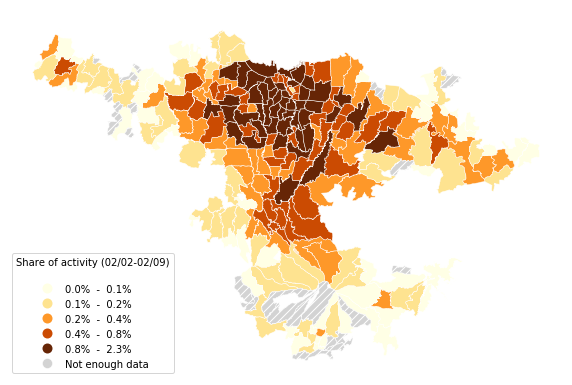

In [7]:
df=activity[(activity.home==0)].copy()
df.loc[(df.pings_final<=700),'pings_initial']=np.nan # More than 100 pings per day
df['share_initial']=df['pings_initial']/df['pings_initial'].sum()*100
name='Share of activity ('+initial_date.strftime('%m/%d')+'-'+(initial_date+timedelta(days=7)).strftime('%m/%d')+')'
mobility_map(df,'share_initial',name)

map-share-of-activity-(04-05-04-12)-Jakarta.pdf


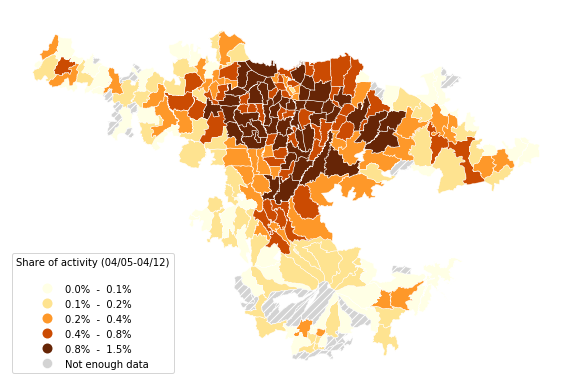

In [8]:
df=activity[(activity.home==0)].copy()
df.loc[(df.pings_final<=700),'pings_final']=np.nan # More than 100 pings per day
df['share_final']=df['pings_final']/df['pings_final'].sum()*100
name='Share of activity ('+final_date.strftime('%m/%d')+'-'+(final_date+timedelta(days=7)).strftime('%m/%d')+')'
mobility_map(df,'share_final',name)

In [9]:
def mobility_map(df,col,name):
    fig, ax = plt.subplots(1, figsize=(10, 10))
    plot=df.plot(
    ax=ax,
    column=col, 
    edgecolor='white', 
    linewidth=0.5,
    legend=True, 
    cmap='RdYlGn_r', 
    scheme='quantiles',
    missing_kwds={"color": "lightgrey","hatch": "///","label": "Not enough data",},
    legend_kwds={'loc': 'lower left','title':name+'\n'})
    ax.axis('off')
    leg = plot.get_legend()
    for lbl in leg.get_texts()[:-1]:
        label_text = lbl.get_text()
        lower = label_text.split()[0]
        upper = label_text.split()[2]
        new_text = f'{float(lower):,.0f}%  -  {float(upper):,.0f}%'
        lbl.set_text(new_text)
    filename='map-'+name.replace(' ','-').replace('/','-').lower()+'-'+city_name+'.pdf'
    print(filename)
    plt.savefig(os.path.join(path_to_data,'../fig/'+filename), bbox_inches='tight')

map-change-in-activity-Jakarta.pdf


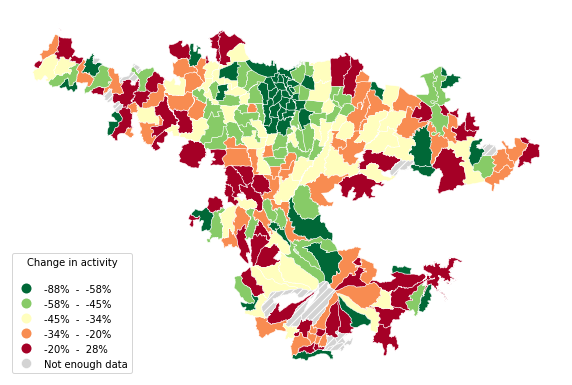

In [10]:
df=activity[(activity.home==0)].copy()
df['activity_change']=df['activity_change']*100
df.loc[(df.pings_initial<=700),'activity_change']=np.nan # More than 100 pings per day
mobility_map(df,'activity_change','Change in activity')